In [103]:
import sys
sys.path.append('../')
import numpy as np
import jax
import jax.numpy as jnp
from jax import random
import optax
from functools import partial
import matplotlib.pyplot as plt
from windows import initInterval, cosine, norm, unnorm
from matrix_builder import generate_indices
from matrix_builder import elmfbpinn

key = random.PRNGKey(42)

# Define the exact solution for the damped harmonic oscillator
m = 1
delta = 2
mu = 2 * delta
omega_0 = 80
k = omega_0**2
omega = jnp.sqrt(omega_0**2 - delta**2)

def harm_u_exact(t):
    phi = jnp.arctan(-delta / omega)
    A = 1 / (2 * jnp.cos(phi))
    return 2 * A * jnp.exp(-delta * t) * jnp.cos(phi + omega * t)

def zero_RHS(t):
    return 0.0 * harm_u_exact(t)

def initWeightBiases(nSubdomains, layer):
    params_hidden = []  # To store hidden layer parameters
    for i in range(len(layer) - 2):  # Loop through hidden layers only
        key = random.PRNGKey(i)
        w_key, b_key, key = random.split(key, 3)
        
        # Calculate weight initialization scale
        v = jnp.sqrt(2. / (layer[i] + layer[i + 1]))
        
        # Initialize weights with shape (current layer size, next layer size)
        W = random.uniform(w_key, (layer[i], layer[i + 1]), minval=-v, maxval=v)
        
        # Initialize biases with shape (next layer size,)
        b = random.uniform(b_key, (layer[i + 1],), minval=-v, maxval=v)
        
        params_hidden.append((W, b))
    
    # Output layer (unique weights and biases for each subdomain)
    key = random.PRNGKey(len(layer) - 2)  # Ensure a new key for the output layer
    w_key, b_key, key = random.split(key, 3)
    v = jnp.sqrt(2. / (layer[-2] + layer[-1]))
    
    # Initialize output weights with shape (nSubdomains, current layer size, output size)
    W_out = random.uniform(w_key, (nSubdomains, layer[-2], layer[-1]), minval=-v, maxval=v)
    
    # Initialize output biases with shape (nSubdomains, output size)
    b_out = random.uniform(b_key, (nSubdomains, layer[-1]), minval=-v, maxval=v)
    
    params_out = (W_out, b_out)
    
    return params_hidden, params_out

def initInterval(nSubdomains, xmin, xmax):
    width = (xmax - xmin) / nSubdomains
    xc = jnp.linspace(xmin, xmax, nSubdomains)
    xmins = xc - width
    xmaxs = xc + width
    return jnp.stack([xmins, xmaxs], axis=-1)

# Normalization and denormalization functions
def norm(mu, sd, x):
    return (x - mu) / sd

def unnorm(mu, sd, x):
    return x * sd + mu

# Forward pass through the neural network
def forward(x, params_hidden, params_outer_layer,sigma):
    #print(f"x shape before hidden layer: {x.shape}")
    for weight, bias in params_hidden:
        #print(f"hidden weight shape: {weight.shape}")
        #print(f"hidden bias shape: {bias.shape}")
        x = sigma(jnp.dot(x, weight) + bias)
        
    #print(f"x shape post hidden: {x.shape}")
        
    final_weight, final_bias = params_outer_layer
    #print(final_weight.shape)
    #print(final_bias.shape)
    return jnp.dot(x, final_weight) + final_bias

# Function to be vmapped across the x points and subdomains
def inner(params_hidden, params_outer_layer, ranges, x,sigma):
    xmin, xmax = ranges
    mu = (xmin + xmax) / 2
    sd = (xmax - xmin) / 2

    # Window function (POU) applied to the subdomain
    w = cosine(xmin, xmax, x)  # Window function
    x = norm(mu, sd, x)  # Normalize x
    x = forward(x, params_hidden, (params_outer_layer),sigma)  # Apply forward pass with subdomain-specific final layer
    x = unnorm(0, 1, x)  # Unnormalize x

    return w * x

def cosine(xmin,xmax, x):
    mu, sd = (xmin+xmax)/2, (xmax-xmin)/2
    ws = ((1+jnp.cos(jnp.pi*(x-mu)/sd))/2)**2
    ws = jnp.heaviside(x-xmin,1)*jnp.heaviside(xmax-x,1)*ws
    w = jnp.prod(ws, axis=0, keepdims=True)
    return w

# Partition of Unity window function
def window_hat(x, xmin, xmax):
    condition = jnp.logical_and(x >= xmin, x <= xmax)
    mu = (xmin + xmax) / 2.0
    sd = (xmax - xmin) / 2.0
    return jnp.where(condition, (1 + jnp.cos(jnp.pi * (x - mu) / sd)) ** 2, 0)

def POU(x, j, xmins, xmaxs, J):
    w_k = jnp.array([window_hat(x, xmins[k], xmaxs[k]) for k in range(J)])
    w_j = window_hat(x, xmins[j], xmaxs[j])
    return w_j / jnp.sum(w_k)

def model(params, ranges, x,sigma):
    # Compute the contributions from each subdomain for each collocation point
    us = jax.vmap(
        jax.vmap(inner, in_axes=(None, None, None, 0,None)),  # Inner vmap for each collocation point (x)
        in_axes=(None, 0, 0, None,None)  # Outer vmap for each subdomain (j)
    )(params[0], params[1], ranges, x,sigma)  # Pass both params_hidden and params_outer_layers

    # Sum the contributions from each subdomain (axis 1)
    u = jnp.sum(us, axis=0)
    
    return u

#supervised loss
def loss_fn(params, ranges, x, y,sigma):
    # Get the model predictions
    u = model(params, ranges, x,sigma)
    
    # Compute the mean squared error loss
    return jnp.mean((u - y) ** 2)

# Training step
from jax import jit
@partial(jax.jit, static_argnums=(5,6))
def train_step(params, ranges, opt_state, x, y, optimizer,sigma):
    # Compute the gradient of the loss function
    loss, grads = jax.value_and_grad(loss_fn, has_aux=False)(params, ranges, x, y,sigma)

    # Apply the updates to the parameters
    updates, opt_state = optimizer.update(grads, opt_state)

    # Apply the updates to the entire params
    params = optax.apply_updates(params, updates)

    return params, opt_state, loss

# Define parameters
layer_sizes = [1, 32, 1] 
learning_rate = 1e-3
epochs = 100000
J = 20
xmin, xmax = 0, 1
sin_params = initWeightBiases(J, layer_sizes)
ranges = initInterval(J, xmin, xmax)
x_train = jnp.linspace(xmin, xmax, 1000).reshape(-1, 1)
y_train = harm_u_exact(x_train)
sigma = jnp.sin

# Initialize optimiser
key, subkey = random.split(key)
optimizer = optax.adam(learning_rate)
opt_state = optimizer.init(sin_params)

# Training loop
# loss_values = []
for epoch in range(epochs):
    sin_params, opt_state, loss = train_step(sin_params, ranges, opt_state, x_train, y_train, optimizer,sigma)
    if epoch % 1000 == 0:
        print(f"Epoch {epoch}, Loss: {loss:.6f}")

Epoch 0, Loss: 0.123883
Epoch 1000, Loss: 0.000528
Epoch 2000, Loss: 0.000527
Epoch 3000, Loss: 0.000526
Epoch 4000, Loss: 0.000524
Epoch 5000, Loss: 0.000522
Epoch 6000, Loss: 0.000519
Epoch 7000, Loss: 0.000515
Epoch 8000, Loss: 0.000463
Epoch 9000, Loss: 0.000006


In [146]:
def basis_pretrain(layer_sizes, J, xmin, xmax, nSamples, epochs, epoch_print, learning_rate, sigma, harm_u_exact):
    # Initialize random key and parameters
    key = random.PRNGKey(42)
    
    # Initialize the weights and biases for the hidden and output layers
    params = initWeightBiases(J, layer_sizes)
    
    # Initialize the subdomains
    ranges = initInterval(J, xmin, xmax)
    
    # Create training data
    x_train = jnp.linspace(xmin, xmax, nSamples).reshape(-1, 1)
    y_train = harm_u_exact(x_train)
    
    # Initialize optimizer (Adam optimizer)
    key, subkey = random.split(key)
    optimizer = optax.adam(learning_rate)
    opt_state = optimizer.init(params)
    
    # Training loop
    for epoch in range(epochs):
        # Perform one training step
        params, opt_state, loss = train_step(params, ranges, opt_state, x_train, y_train, optimizer, sigma)
        
        # Print loss every 1000 epochs
        if epoch % epoch_print == 0:
            print(f"Epoch {epoch}, Loss: {loss:.9f}")
    
    # Return the trained parameters, optimizer state, and final loss
    return params,ranges, opt_state, loss

In [144]:
layer_sizes = [1, 32, 1]
J = 20
xmin, xmax = 0, 1
nSamples = 1000
epochs = 100000
epoch_print = epochs/10
learning_rate = 1e-3

In [147]:
sin_params, sin_ranges, sin_opt_state, sin_loss = basis_pretrain(layer_sizes, J, xmin, xmax, nSamples, epochs,epoch_print, learning_rate, jnp.sin, harm_u_exact)

Epoch 0, Loss: 0.136360109
Epoch 10000, Loss: 0.000002947
Epoch 20000, Loss: 0.000002275
Epoch 30000, Loss: 0.000000663
Epoch 40000, Loss: 0.000000768
Epoch 50000, Loss: 0.000000593
Epoch 60000, Loss: 0.000000578
Epoch 70000, Loss: 0.000000847
Epoch 80000, Loss: 0.000000555
Epoch 90000, Loss: 0.000000585


In [148]:
tanh_params, tanh_ranges, tanh_opt_state, tanh_loss = basis_pretrain(layer_sizes, J, xmin, xmax,nSamples, epochs,epoch_print, learning_rate, jnp.tanh, harm_u_exact)

Epoch 0, Loss: 0.136362806
Epoch 10000, Loss: 0.000004928
Epoch 20000, Loss: 0.000000200
Epoch 30000, Loss: 0.000000218
Epoch 40000, Loss: 0.000000225
Epoch 50000, Loss: 0.000000064
Epoch 60000, Loss: 0.000000060
Epoch 70000, Loss: 0.000000137
Epoch 80000, Loss: 0.000000147
Epoch 90000, Loss: 0.000000068


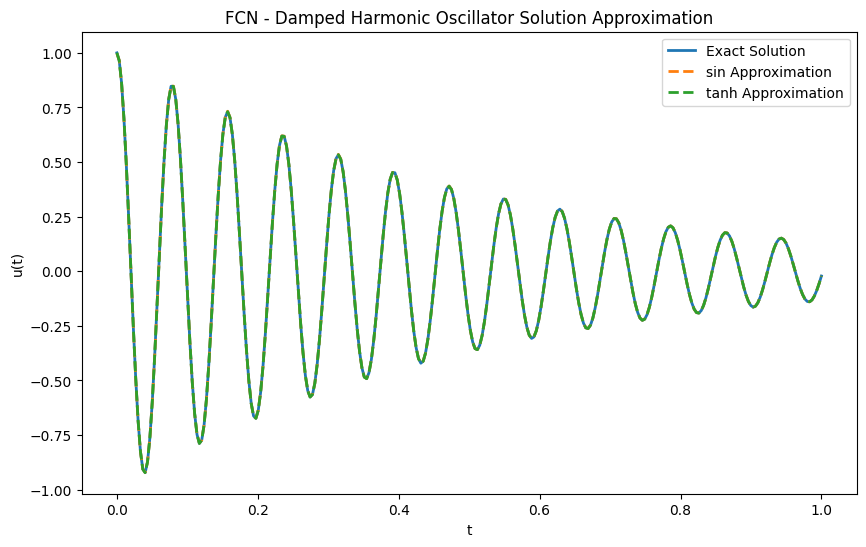

In [151]:
import matplotlib.pyplot as plt

# Evaluate the model
sin_u_pred = model(sin_params, sin_ranges, x_train,jnp.sin)
tanh_u_pred = model(tanh_params, tanh_ranges, x_train,jnp.tanh)

# Plot the results
plt.figure(figsize=(10, 6))
plt.plot(x_train, y_train, label="Exact Solution", linewidth=2)
plt.plot(x_train, sin_u_pred, label="sin Approximation", linestyle="--",linewidth=2)
plt.plot(x_train, tanh_u_pred, label="tanh Approximation", linestyle="--", linewidth=2)
plt.xlabel("t")
plt.ylabel("u(t)")
plt.title("FCN - Damped Harmonic Oscillator Solution Approximation")
plt.legend()
plt.show()


In [156]:
import numpy as np

# Function to evaluate activations of the hidden units
def get_hidden_activations(x_vals, params,sigma):
    activations = []
    x = x_vals
    for weight, bias in params[0]:  # Iterate over all hidden layers
        x = sigma(jnp.dot(x, weight) + bias)
        activations.append(x)
    
    plt.figure(figsize=(15, 10))
    for i, activation in enumerate(activations):
        plt.plot(x_vals, activation, label=f'Hidden Unit {i+1}')
        
    plt.xlabel('Input x')
    plt.ylabel('Activation')
    plt.title(f'Activation of Hidden Units: {sigma.__name__}')
    plt.grid()
    plt.show()
    return activations

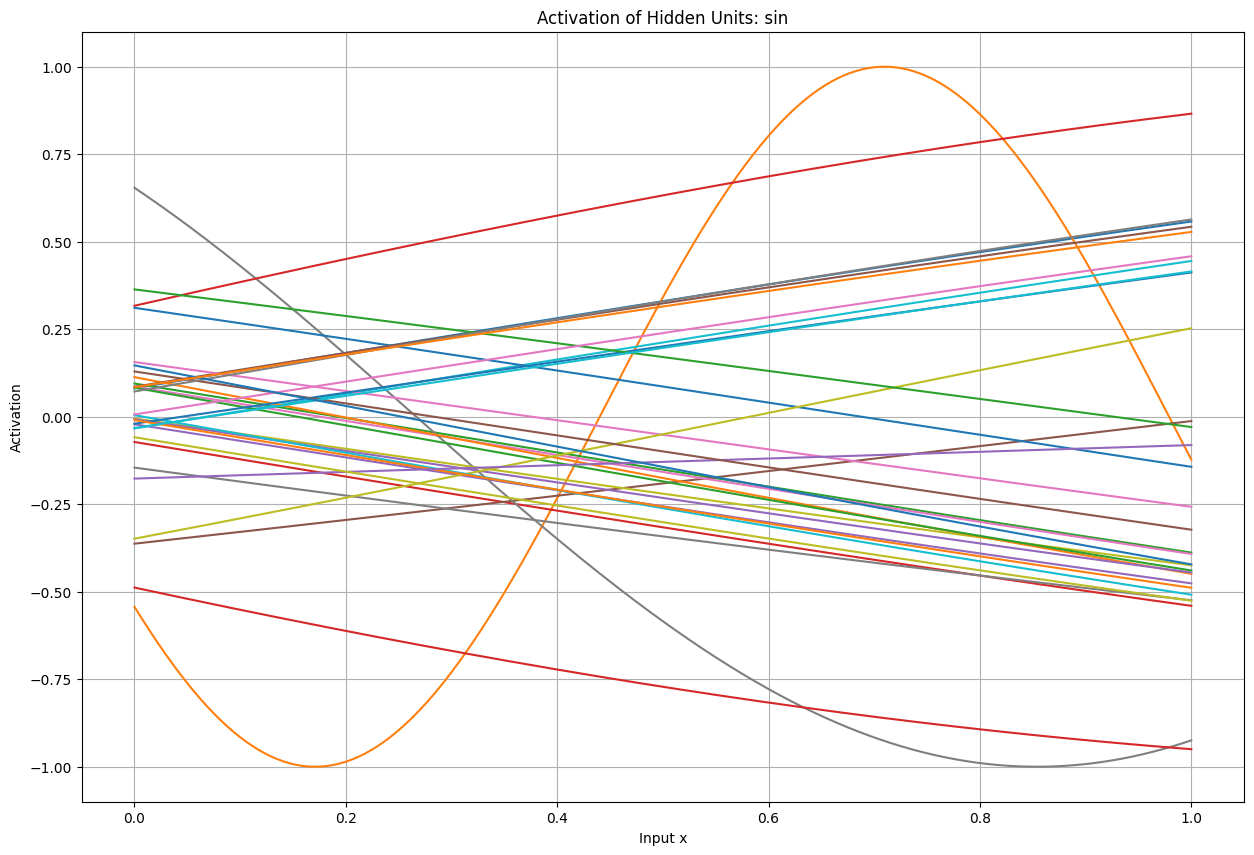

In [157]:
# Generate a set of x values to evaluate the activations
x_vals = jnp.linspace(0, 1, nSamples).reshape(-1, 1)
# Get the activations for the hidden units
hidden_activations = get_hidden_activations(x_vals, sin_params,jnp.sin)


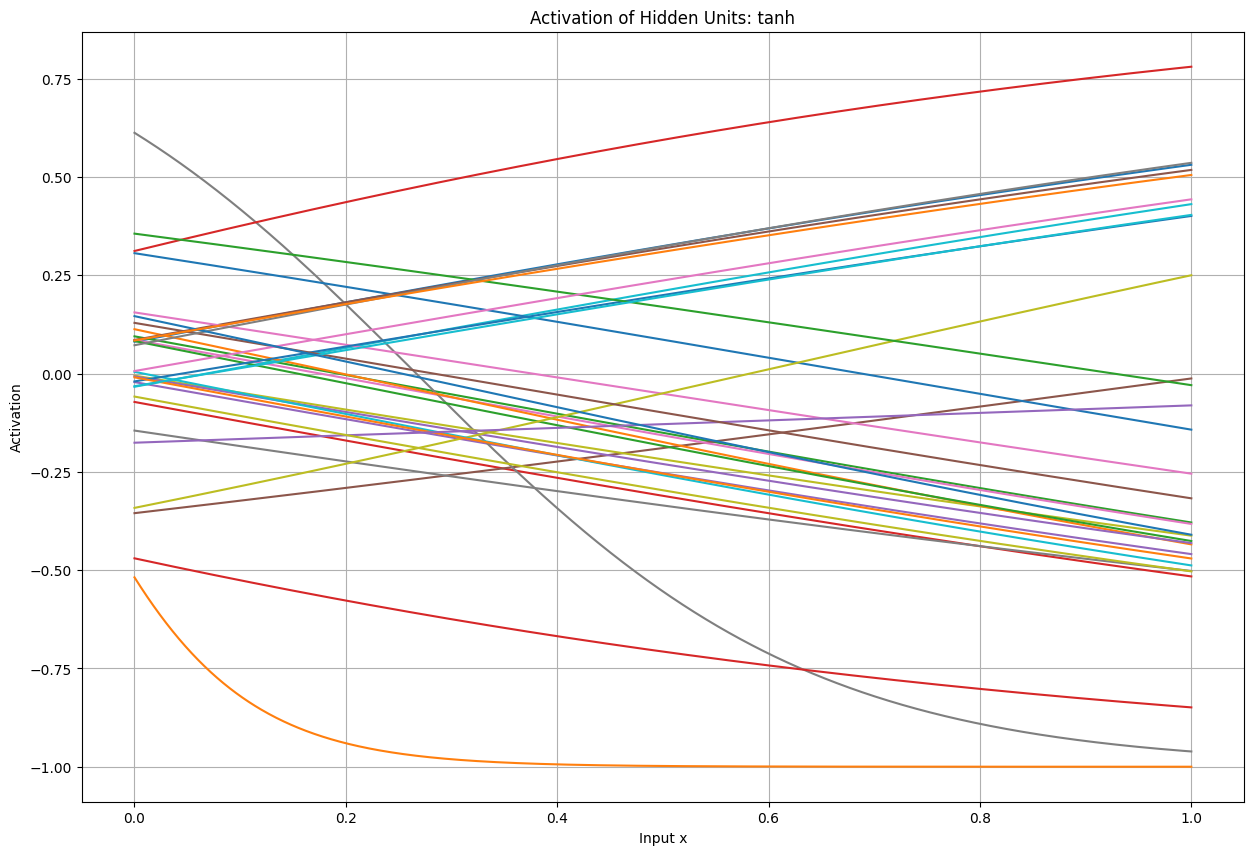

In [158]:
hidden_activations = get_hidden_activations(x_vals, sin_params,jnp.tanh)

### Sin params

Creating M_ode...
M_ode created in 2.42 seconds.
exact_solution scaled.
Creating B_train...
B_train created in 0.58 seconds.
B_train scaled
Time taken for solver: 0.0068 seconds
a calculated in 0.35 seconds.
Creating M_sol...
M_sol created in 1.96 seconds.
Loss Value: 3.92e-01
Test Loss Value: 3.92e-01


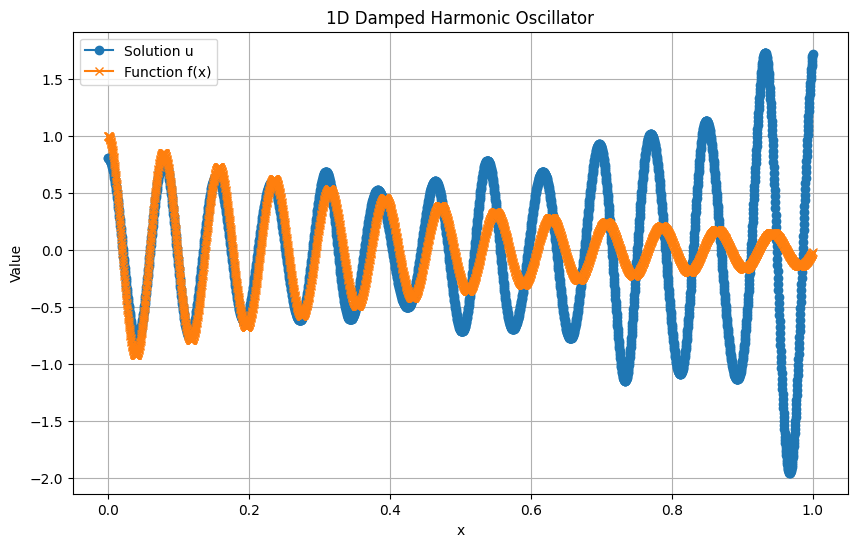

Condition number of M_ode_scaled: 3.34e+11
Condition number of M_sol: 4.20e+10
Condition Number of LHS: 1.28e+12
Total time taken: 7.27 seconds.


In [166]:
params_hidden, params_out = sin_params
hidden_weights = params_hidden[0][0]
hidden_biases = params_hidden[0][1]

RHS_func = zero_RHS
u_func = harm_u_exact
n_train = 1000
n_test = 3000
J=20
C=32
R=25
width = 1.9
sigma = jnp.sin
xmin,xmax= 0,1
title = "1D Damped Harmonic Oscillator"
results = elmfbpinn(
    RHS_func,
    u_func,
    n_train,
    n_test,
    J,
    C,
    R,
    xmin,
    xmax,
    width,
    sigma,
    title,
    weights=hidden_weights.reshape(-1),
    biases=hidden_biases.reshape(-1),
    lmda=1,
    plot_window=False,
)

#### Random weights - Sin

Creating M_ode...
M_ode created in 1.26 seconds.
exact_solution scaled.
Creating B_train...
B_train created in 0.59 seconds.
B_train scaled
Time taken for solver: 0.0065 seconds
a calculated in 0.07 seconds.
Creating M_sol...
M_sol created in 0.23 seconds.
Loss Value: 3.94e-02
Test Loss Value: 3.94e-02


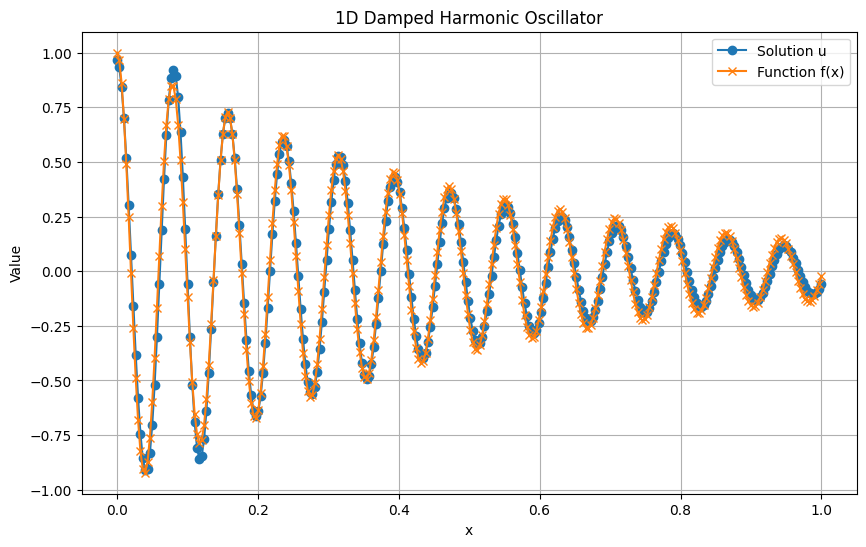

Condition number of M_ode_scaled: 3.73e+11
Condition number of M_sol: 1.34e+12
Condition Number of LHS: 1.38e+12
Total time taken: 2.54 seconds.


In [165]:
RHS_func = zero_RHS
u_func = harm_u_exact
n_train = 150
n_test = 300
J=20
C=32
R=0.2
width = 1.9
sigma = jnp.sin
xmin,xmax= 0,1
title = "1D Damped Harmonic Oscillator"
results = elmfbpinn(
    RHS_func,
    u_func,
    n_train,
    n_test,
    J,
    C,
    R,
    xmin,
    xmax,
    width,
    sigma,
    title,
    weights=None,
    biases=None,
    lmda=1,
    plot_window=False,
)

#### tanh_params

Creating M_ode...
M_ode created in 1.66 seconds.
exact_solution scaled.
Creating B_train...
B_train created in 0.70 seconds.
B_train scaled
Time taken for solver: 0.0092 seconds
a calculated in 0.11 seconds.
Creating M_sol...
M_sol created in 0.26 seconds.
Loss Value: 6.62e-01
Test Loss Value: 6.62e-01


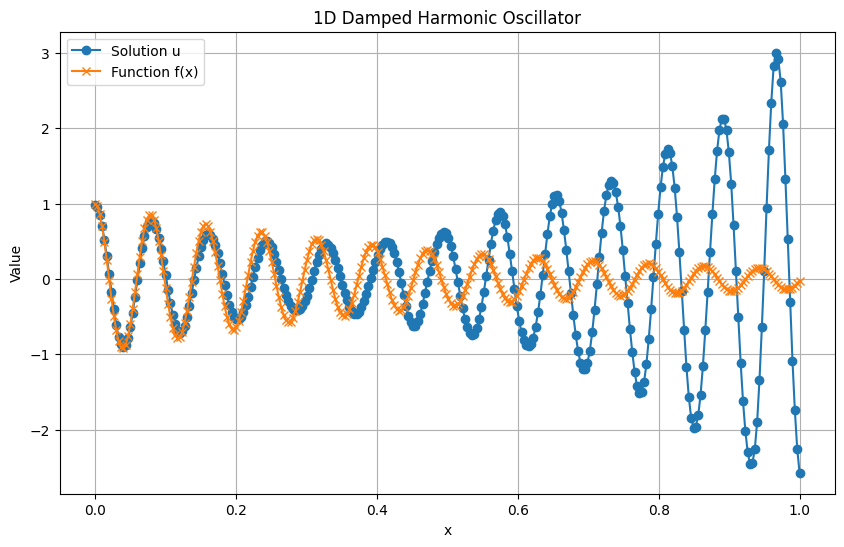

Condition number of M_ode_scaled: 3.44e+10
Condition number of M_sol: 4.58e+10
Condition Number of LHS: 1.81e+14
Total time taken: 3.11 seconds.


In [110]:
params_hidden, params_out = tanh_params
hidden_weights = params_hidden[0][0]
hidden_biases = params_hidden[0][1]

RHS_func = zero_RHS
u_func = harm_u_exact
n_train = 150
n_test = 300
J=25
C=32
R=1
width = 1.9
sigma = jnp.tanh
xmin,xmax= 0,1
title = "1D Damped Harmonic Oscillator"
results = elmfbpinn(
    RHS_func,
    u_func,
    n_train,
    n_test,
    J,
    C,
    R,
    xmin,
    xmax,
    width,
    sigma,
    title,
    weights=hidden_weights.reshape(-1),
    biases=hidden_biases.reshape(-1),
    lmda=1,
    plot_window=False,
)

Random weights - tanh

Creating M_ode...
M_ode created in 1.51 seconds.
exact_solution scaled.
Creating B_train...
B_train created in 0.67 seconds.
B_train scaled
Time taken for solver: 0.0093 seconds
a calculated in 0.10 seconds.
Creating M_sol...
M_sol created in 0.26 seconds.
Loss Value: 3.31e-01
Test Loss Value: 3.31e-01


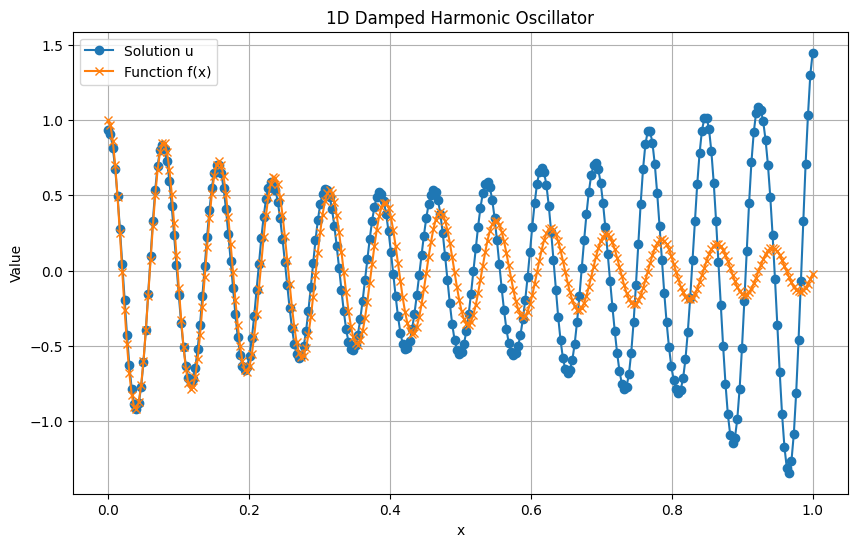

Condition number of M_ode_scaled: 1.07e+10
Condition number of M_sol: 4.60e+10
Condition Number of LHS: 3.40e+12
Total time taken: 2.86 seconds.


In [123]:
params_hidden, params_out = tanh_params
hidden_weights = params_hidden[0][0]
hidden_biases = params_hidden[0][1]

RHS_func = zero_RHS
u_func = harm_u_exact
n_train = 150
n_test = 300
J=25
C=32
R=1
width = 1.9
sigma = jnp.tanh
xmin,xmax= 0,1
title = "1D Damped Harmonic Oscillator"
results = elmfbpinn(
    RHS_func,
    u_func,
    n_train,
    n_test,
    J,
    C,
    R,
    xmin,
    xmax,
    width,
    sigma,
    title,
    weights=None,
    biases=None,
    lmda=1,
    plot_window=False,
)